In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

2024-06-06 09:16:16.037893: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-06 09:16:16.037954: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-06 09:16:16.037985: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-06 09:16:16.046263: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('dataset/windows/windowed_3.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811200 entries, 0 to 811199
Data columns (total 12 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   time    811200 non-null  int64 
 1   A_F     811200 non-null  int64 
 2   A_V     811200 non-null  int64 
 3   A_L     811200 non-null  int64 
 4   L_F     811200 non-null  int64 
 5   L_V     811200 non-null  int64 
 6   L_L     811200 non-null  int64 
 7   T_F     811200 non-null  int64 
 8   T_V     811200 non-null  int64 
 9   T_L     811200 non-null  int64 
 10  Action  811200 non-null  int64 
 11  name    811200 non-null  object
dtypes: int64(11), object(1)
memory usage: 74.3+ MB


In [4]:
# 'name' 열에서 2, 3번째 숫자를 추출하여 새로운 열 'user_number' 생성
df['user_number'] = df['name'].str[1:3]

# 'user_number' 열을 int형으로 변환
df['user_number'] = df['user_number'].astype(int)

# 기존 'name' 열 삭제
df.drop(columns=['name'], inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811200 entries, 0 to 811199
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   time         811200 non-null  int64
 1   A_F          811200 non-null  int64
 2   A_V          811200 non-null  int64
 3   A_L          811200 non-null  int64
 4   L_F          811200 non-null  int64
 5   L_V          811200 non-null  int64
 6   L_L          811200 non-null  int64
 7   T_F          811200 non-null  int64
 8   T_V          811200 non-null  int64
 9   T_L          811200 non-null  int64
 10  Action       811200 non-null  int64
 11  user_number  811200 non-null  int64
dtypes: int64(12)
memory usage: 74.3 MB


In [6]:
print(df.dtypes)

time           int64
A_F            int64
A_V            int64
A_L            int64
L_F            int64
L_V            int64
L_L            int64
T_F            int64
T_V            int64
T_L            int64
Action         int64
user_number    int64
dtype: object


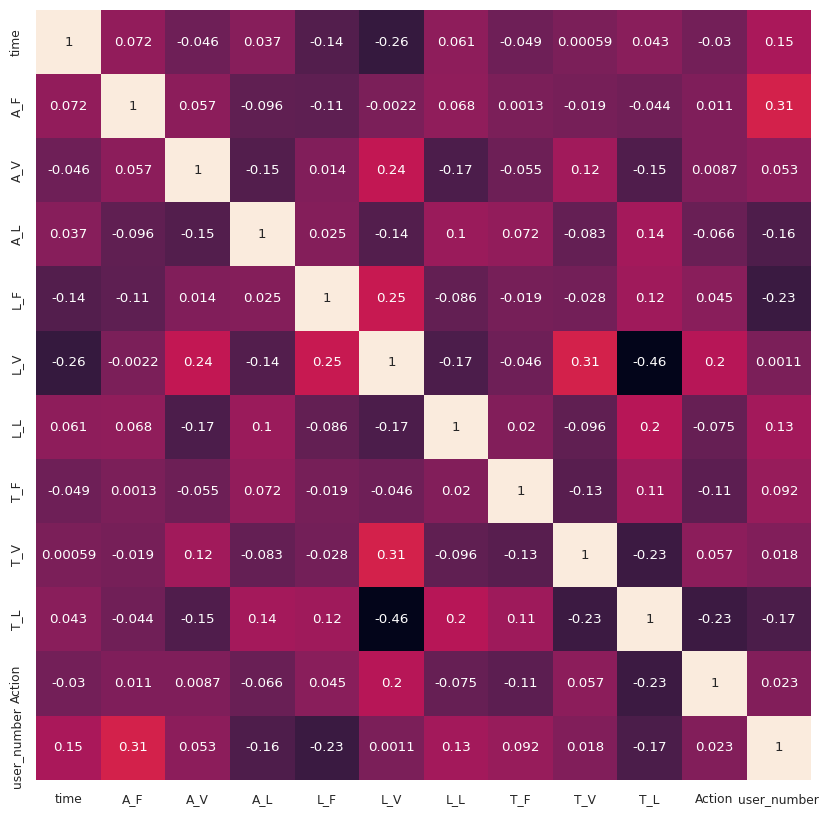

In [7]:
# 히트맵 그리기
df_corr = df.corr()

# 히트맵 그리기
plt.figure(figsize=(10, 10))
sns.set(font_scale=0.8)
mask = np.zeros(df_corr.shape, dtype=bool)  # 여기에 문제가 있을 수 있습니다.
sns.heatmap(df_corr, annot=True, cbar=False, mask=mask)
plt.show()

In [8]:
df.shape

(811200, 12)

In [9]:
df['Action'].value_counts()

0    664000
1    101952
2     45248
Name: Action, dtype: int64

In [10]:
# status 열에서 값이 0인 행 제거
df = df[df['Action'] != 0]

# status 열에서 값이 1인 행을 0으로, 값이 2인 행을 1로 바꾸기
df['Action'] = df['Action'].replace({1: 0, 2: 1})

In [11]:
df['Action'].value_counts()

0    101952
1     45248
Name: Action, dtype: int64

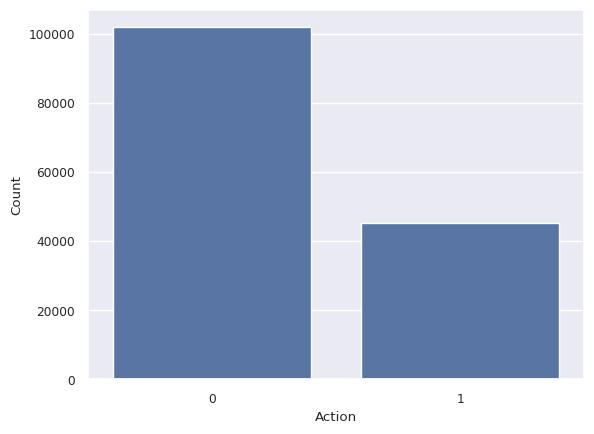

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and '0' is the column name
# Ensure the column is of categorical dtype
df['Action'] = df['Action'].astype('category')

# Now plot
sns.countplot(data=df, x="Action")
plt.xlabel("Action")
plt.ylabel("Count")
plt.show()

In [13]:
def split_sequence(X, y, n_steps):
    X_seq, y_seq = list(), list()
    for i in range(len(X) - n_steps + 1):
        end_ix = i + n_steps
        seq_x = X[i:end_ix]
        seq_y = y[end_ix-1]
        X_seq.append(seq_x)
        y_seq.append(seq_y)
    return np.array(X_seq), np.array(y_seq)

In [14]:
X = df[['A_L', 'L_V', 'L_L', 'T_F','T_L']]
y = df['Action'].to_numpy()

In [15]:
n_steps = 6

In [16]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [17]:
X, y = split_sequence(X, y, n_steps)

In [18]:
Y = to_categorical(y)
Y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [19]:
X_train, X_test, y_train, y_test =  train_test_split(X, Y, test_size = 0.2, random_state = 0, stratify = y)

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train , test_size = 0.2, random_state = 0, stratify = y_train)

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((94204, 6, 5), (29439, 6, 5), (94204, 2), (29439, 2))

In [22]:
n_timesteps,n_features,n_outputs= X_train.shape[1],X_train.shape[2],y_train.shape[1]

In [23]:
model = keras.Sequential()
model.add(keras.layers.Dense(50, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Dense(100, activation='relu'))
model.add(LSTM(100))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_outputs, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]

2024-06-06 09:16:22.289663: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38698 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:4c:00.0, compute capability: 8.0
2024-06-06 09:16:22.292143: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38698 MB memory:  -> device: 1, name: CUDA GPU, pci bus id: 0000:c8:00.0, compute capability: 8.0


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6, 50)             300       
                                                                 
 dense_1 (Dense)             (None, 6, 100)            5100      
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 batch_normalization (Batch  (None, 100)               400       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 202       
                                                        

In [24]:
print(f"X_train type: {type(X_train)}")
print(f"y_train type: {type(y_train)}")
print(f"X_val type: {type(X_val)}")
print(f"y_val type: {type(y_val)}")

X_train type: <class 'numpy.ndarray'>
y_train type: <class 'numpy.ndarray'>
X_val type: <class 'numpy.ndarray'>
y_val type: <class 'numpy.ndarray'>


In [25]:
# 데이터 타입 확인
print("Checking data types...")
print(f"X_train dtype: {X_train.dtype}")
print(f"y_train dtype: {y_train.dtype}")
print(f"X_val dtype: {X_val.dtype}")
print(f"y_val dtype: {y_val.dtype}")

Checking data types...
X_train dtype: float64
y_train dtype: float32
X_val dtype: float64
y_val dtype: float32


In [26]:
epochs, batch_size = 100, 64
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val), shuffle=True, callbacks=callbacks)

Epoch 1/100


2024-06-06 09:16:25.144423: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-06-06 09:16:26.493676: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f60987ecca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-06 09:16:26.493723: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): CUDA GPU, Compute Capability 8.0
2024-06-06 09:16:26.493734: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): CUDA GPU, Compute Capability 8.0
2024-06-06 09:16:26.498880: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-06 09:16:26.580706: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1472/1472 [==============================] - 13s 6ms/step - loss: 0.6074 - accuracy: 0.6913 - val_loss: 0.5952 - val_accuracy: 0.6973
Epoch 2/100
1472/1472 [==============================] - 8s 6ms/step - loss: 0.5744 - accuracy: 0.7109 - val_loss: 0.5713 - val_accuracy: 0.7151
Epoch 3/100
1472/1472 [==============================] - 8s 6ms/step - loss: 0.5651 - accuracy: 0.7188 - val_loss: 0.5610 - val_accuracy: 0.7228
Epoch 4/100
1472/1472 [==============================] - 8s 5ms/step - loss: 0.5574 - accuracy: 0.7232 - val_loss: 0.5523 - val_accuracy: 0.7284
Epoch 5/100
1472/1472 [==============================] - 8s 5ms/step - loss: 0.5492 - accuracy: 0.7278 - val_loss: 0.5471 - val_accuracy: 0.7317
Epoch 6/100
1472/1472 [==============================] - 9s 6ms/step - loss: 0.5443 - accuracy: 0.7316 - val_loss: 0.5452 - val_accuracy: 0.7317
Epoch 7/100
1472/1472 [==============================] - 8s 6ms/step - loss: 0.5373 - accuracy: 0.7345 - val_loss: 0.5424 - val_accuracy: 0.7

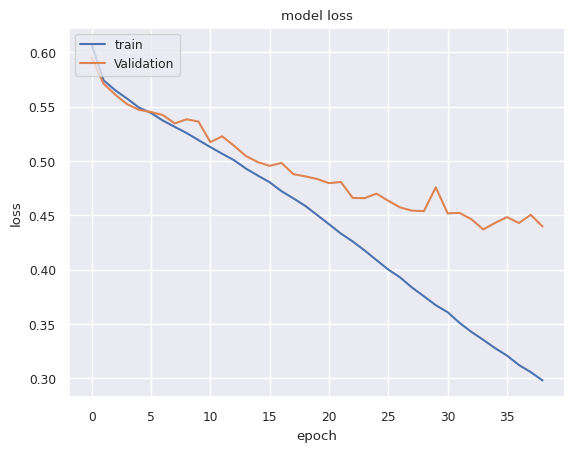

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

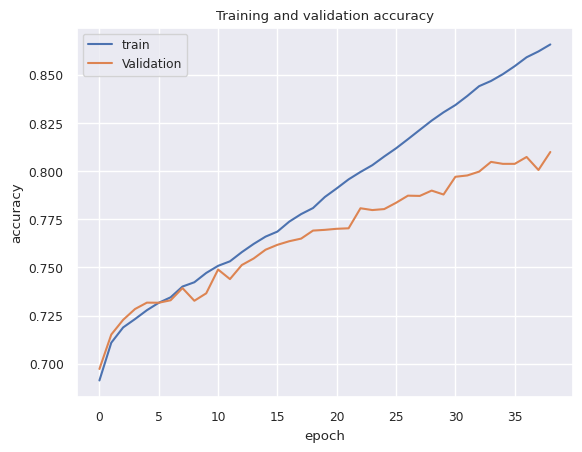

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

920/920 [==============================] - 2s 2ms/step
f1_score =  0.7986453711899636
0.805665953327219
              precision    recall  f1-score   support

           0       0.83      0.91      0.87     20389
           1       0.73      0.58      0.65      9050

    accuracy                           0.81     29439
   macro avg       0.78      0.74      0.76     29439
weighted avg       0.80      0.81      0.80     29439



(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

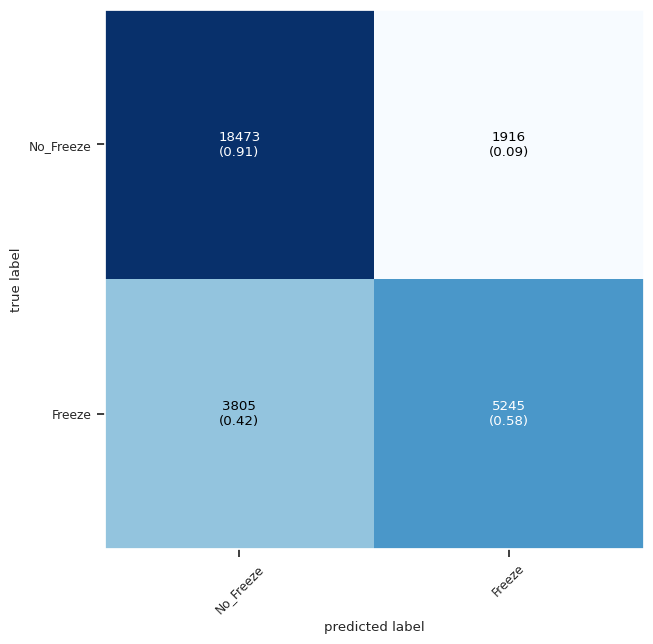

In [29]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import numpy as np

# 모델 예측
predy = model.predict(X_test)
predy = np.argmax(predy, axis=-1)
y_true = np.argmax(y_test, axis=-1)

LABELS = ['No_Freeze', 'Freeze']
cm = confusion_matrix(y_true, predy)

# 결과 출력
print('f1_score = ', f1_score(y_true, predy, average='weighted'))
print(accuracy_score(y_true, predy))
print(classification_report(y_true, predy))

# 혼동 행렬 시각화
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7, 7))

### SMOTE() 오버 샘플링

In [30]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(df.drop('Action', axis=1), df['Action'])

In [31]:
df = pd.concat([pd.DataFrame(X_resampled, columns=df.drop('Action', axis=1).columns),
                         pd.DataFrame({'Action': y_resampled})], axis=1)

In [32]:
print(df['Action'].value_counts())

0    101952
1    101952
Name: Action, dtype: int64


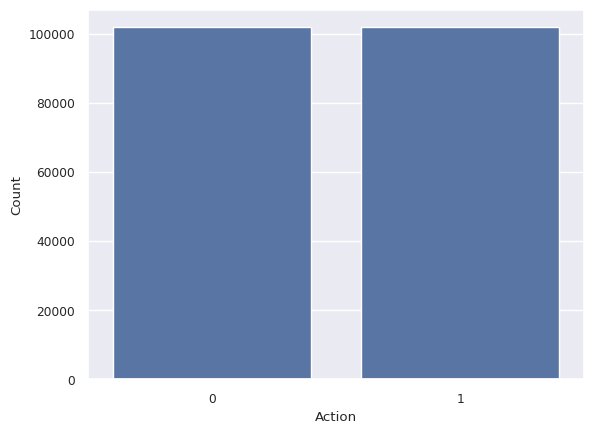

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and '0' is the column name
# Ensure the column is of categorical dtype
df['Action'] = df['Action'].astype('category')

# Now plot
sns.countplot(data=df, x="Action")
plt.xlabel("Action")
plt.ylabel("Count")
plt.show()

In [34]:
X = df[['A_L', 'L_V', 'L_L', 'T_F', 'T_L']]
y = df['Action'].to_numpy()

In [35]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [36]:
X, y = split_sequence(X, y, n_steps)

In [37]:
Y = to_categorical(y)
Y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [38]:
X_train, X_test, y_train, y_test =  train_test_split(X, Y, test_size = 0.2, random_state = 0, stratify = y)

In [39]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train , test_size = 0.2, random_state = 0, stratify = y_train)

In [40]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((130495, 6, 5), (40780, 6, 5), (130495, 2), (40780, 2))

In [41]:
n_timesteps,n_features,n_outputs= X_train.shape[1],X_train.shape[2],y_train.shape[1]

In [42]:
model = keras.Sequential()
model.add(keras.layers.Dense(50, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Dense(100, activation='relu'))
model.add(LSTM(100))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_outputs, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 6, 50)             300       
                                                                 
 dense_4 (Dense)             (None, 6, 100)            5100      
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 batch_normalization_1 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                 202       
                                                      

In [43]:
epochs, batch_size = 100, 64
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val), shuffle=True, callbacks=callbacks)

Epoch 1/100
2039/2039 [==============================] - 14s 6ms/step - loss: 0.6698 - accuracy: 0.6085 - val_loss: 0.6725 - val_accuracy: 0.6062
Epoch 2/100
2039/2039 [==============================] - 12s 6ms/step - loss: 0.6672 - accuracy: 0.5949 - val_loss: 0.6878 - val_accuracy: 0.5438
Epoch 3/100
2039/2039 [==============================] - 12s 6ms/step - loss: 0.6680 - accuracy: 0.5836 - val_loss: 0.6469 - val_accuracy: 0.6632
Epoch 4/100
2039/2039 [==============================] - 13s 6ms/step - loss: 0.6598 - accuracy: 0.6081 - val_loss: 0.6178 - val_accuracy: 0.6855
Epoch 5/100
2039/2039 [==============================] - 12s 6ms/step - loss: 0.6527 - accuracy: 0.6234 - val_loss: 0.6352 - val_accuracy: 0.6744
Epoch 6/100
2039/2039 [==============================] - 12s 6ms/step - loss: 0.6394 - accuracy: 0.6435 - val_loss: 0.6058 - val_accuracy: 0.7020
Epoch 7/100
2039/2039 [==============================] - 12s 6ms/step - loss: 0.6246 - accuracy: 0.6607 - val_loss: 0.5925 -

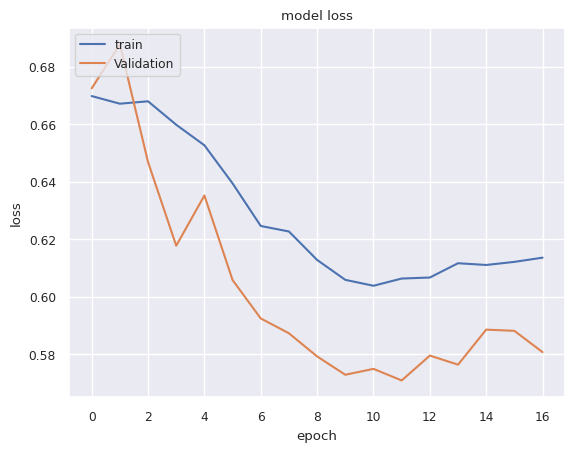

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

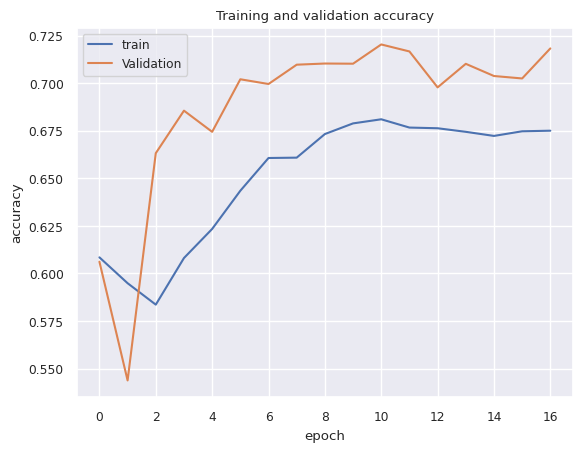

In [45]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

1275/1275 [==============================] - 3s 2ms/step
f1_score =  0.7153985025463302
0.7155468366846494
              precision    recall  f1-score   support

           0       0.71      0.74      0.72     20389
           1       0.73      0.69      0.71     20391

    accuracy                           0.72     40780
   macro avg       0.72      0.72      0.72     40780
weighted avg       0.72      0.72      0.72     40780



(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

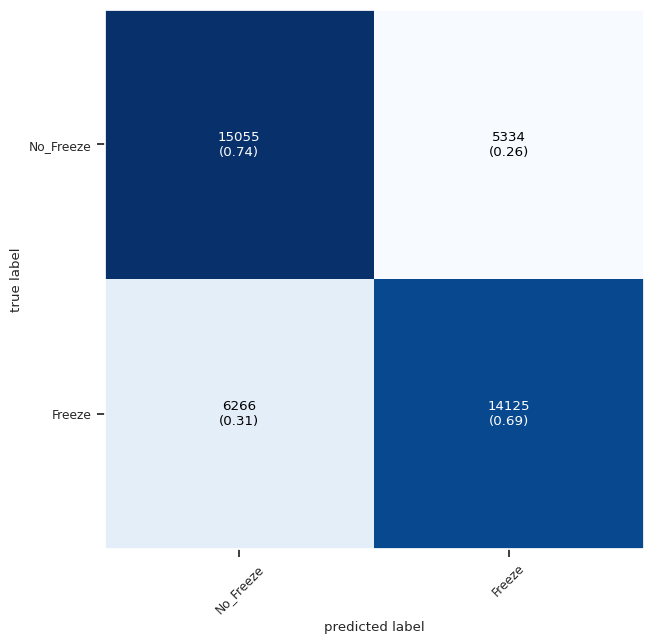

In [46]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import numpy as np

# 모델 예측
predy = model.predict(X_test)
predy = np.argmax(predy, axis=-1)
y_true = np.argmax(y_test, axis=-1)

LABELS = ['No_Freeze', 'Freeze']
cm = confusion_matrix(y_true, predy)

# 결과 출력
print('f1_score = ', f1_score(y_true, predy, average='weighted'))
print(accuracy_score(y_true, predy))
print(classification_report(y_true, predy))

# 혼동 행렬 시각화
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7, 7))